#Data loading

##Import

In [2]:
!pip install kaggle

In [3]:
pip install --upgrade kaggle

Requirement already up-to-date: kaggle in /usr/local/lib/python3.6/dist-packages (1.5.10)


In [4]:
!mkdir .kaggle

In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [6]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Study/Kaggle"

In [7]:
%cd /content/gdrive/My Drive/Study/DL/Assignments/Project

/content/gdrive/My Drive/Study/DL/Assignments/Project


In [8]:
!kaggle competitions download -c final-project-dl-spring-2020


404 - Not Found


In [9]:
!ls

 alexnet_pretrained.pt		    preds_4.1.csv
 final-project-dl-spring-2020.zip   preds_4.1.gsheet
 model_5.pt			    preds_4.2.csv
 model_6.pt			    preds_4.3.csv
 model_7.pt			    preds_5.csv
 model_8.pt			    preds_6.csv
 pred_5.csv			    preds_7.csv
 preds_1.2.csv			    preds_7.gsheet
 preds_1.2.gsheet		    preds_8.csv
 preds_1.3.csv			    preds_8.gsheet
 preds_1.4.csv			    Project.docx
 preds_1.6.csv			    resnet18_pretrained.pt
 preds_1.6.gsheet		    resnet34_pretrained.pt
'preds_1.7 (1).gsheet'		    resnet50_pretrained.pt
 preds_1.7.csv			   '~$roject.docx'
 preds_1.7.gsheet		    sample_submission.csv
 preds_1.csv			    submission.csv
 preds_1.gsheet			    test_data
 preds_3.1.csv			    train_data
 preds_3.1.gsheet


In [10]:
#unzipping the zip files and deleting the zip files
#!unzip \*.zip  && rm *.zip

In [11]:
import torch
import torch.nn as nn

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from datetime import datetime
from pathlib import Path
import pandas as pd
import torch.nn.functional as F
import torchtext.data as ttd
import torchvision
from torchvision import datasets, transforms,utils


from torch.optim.lr_scheduler import StepLR, CyclicLR

In [12]:
folder=Path('/content/gdrive/My Drive/Study/DL/Assignments/Project')

##Data transformation

In [13]:
transformer = transforms.Compose([
#    transforms.Resize(256),
#    transforms.RandomCrop(256),
#    transforms.RandomHorizontalFlip(),
#    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
 #   transforms.Normalize([meanR, meanG, meanB], [stdR, stdG, stdB]),
     ])

In [14]:
train0_ds = datasets.ImageFolder(folder/'train_data/train',transform=transformer)
test_ds = datasets.ImageFolder(folder/'test_data',transform=transformer)

In [15]:
train0_ds.classes

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

##Train/val split

In [16]:
from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(n_splits=1, train_size=0.7, random_state=0)

indices=list(range(len(train0_ds)))
y_train0=[y for _,y in train0_ds]
for train_index, val_index in sss.split(indices, y_train0):
    print("train:", train_index, "val:", val_index)
    print(len(val_index),len(train_index))

train: [5279 5574 7391 ... 8774 2047 3129] val: [1900 5887 8619 ... 5449 1106 6628]
2708 6317


In [17]:
from torch.utils.data import Subset

val_ds=Subset(train0_ds,val_index)
train_ds=Subset(train0_ds,train_index)

In [18]:
print(f'Number of training examples: {len(train_ds)}')
print(f'Number of validation examples: {len(val_ds)}')
print(f'Number of testing examples: {len(test_ds)}')

Number of training examples: 6317
Number of validation examples: 2708
Number of testing examples: 3929


In [19]:
import numpy as np

# RGB mean and std 
meanRGB=[np.mean(x.numpy(),axis=(1,2)) for x,_ in train_ds]
stdRGB=[np.std(x.numpy(),axis=(1,2)) for x,_ in train_ds]

meanR=np.mean([m[0] for m in meanRGB])
meanG=np.mean([m[1] for m in meanRGB])
meanB=np.mean([m[2] for m in meanRGB])

stdR=np.mean([s[0] for s in stdRGB])
stdG=np.mean([s[1] for s in stdRGB])
stdB=np.mean([s[2] for s in stdRGB])

print(meanR,meanG,meanB)
print(stdR,stdG,stdB)

0.48499483 0.45491496 0.39288142
0.22034366 0.21472108 0.21670675


#Preprocessing

In [20]:
#additional transformation changes if required

train_transformer_1 = transforms.Compose([
    transforms.Resize(512),
#    transforms.RandomHorizontalFlip(), # randomly flip and rotate
    transforms.RandomCrop(512),
#    transforms.RandomHorizontalFlip(),
#    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
#    transforms.Normalize([meanR, meanG, meanB], [stdR, stdG, stdB]),
#    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

     ])
                 

test_transformer_1 = transforms.Compose([
    transforms.Resize(512),
    transforms.RandomCrop(512),
    transforms.ToTensor(),
#    transforms.Normalize([meanR, meanG, meanB], [stdR, stdG, stdB]),
#    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

    ])   

train0_ds.transform=train_transformer_1
test_ds.transform=test_transformer_1

##Data loader

In [48]:
from torch.utils.data import DataLoader

train_dl = DataLoader(train_ds, batch_size = 32, shuffle=True, num_workers=4)
val_dl = DataLoader(val_ds, batch_size = 32, shuffle=True, num_workers=4)
test_dl = DataLoader(test_ds, batch_size = 32, shuffle=False, num_workers=4)

##Sample check

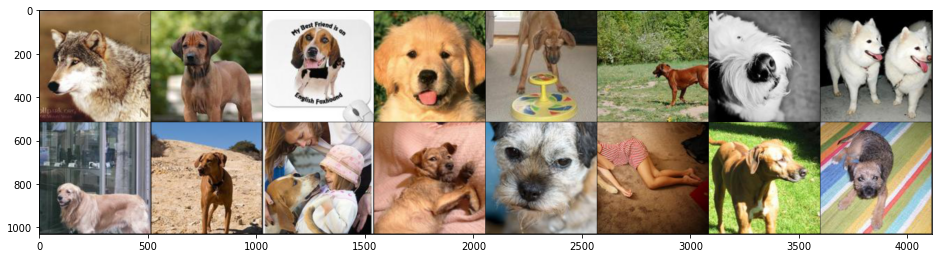

In [46]:
samples, labels = iter(train_dl).next()
plt.figure(figsize=(16,24))
grid_imgs = torchvision.utils.make_grid(samples[:24])
np_grid_imgs = grid_imgs.numpy()
# in tensor, image is (batch, width, height), so you have to transpose it to (width, height, batch) in numpy to show it.
plt.imshow(np.transpose(np_grid_imgs, (1,2,0)))

In [23]:
# extract a batch from training data
for x, y in train_dl:
    print(x.shape)
    print(y.shape)
    break
# extract a batch from val data
for x, y in val_dl:
    print(x.shape)
    print(y.shape)
    break


torch.Size([32, 3, 512, 512])
torch.Size([32])
torch.Size([32, 3, 512, 512])
torch.Size([32])


In [24]:
import collections

# get labels
y_train=[y for _,y in train_ds]

# count labels
counter_train=collections.Counter(y_train)
print(counter_train)

Counter({9: 664, 7: 664, 6: 660, 8: 659, 0: 659, 5: 658, 3: 652, 1: 650, 2: 645, 4: 406})


#Predefined functions

In [25]:
def train_val(model, params):
    # extract model parameters
    num_epochs=params["num_epochs"]
    loss_func=params["loss_func"]
    opt=params["optimizer"]
    train_dl=params["train_dl"]
    val_dl=params["val_dl"]
    sanity_check=params["sanity_check"]
    lr_scheduler=params["lr_scheduler"]
    path2weights=params["path2weights"]
    
    # history of loss values in each epoch
    loss_history={
        "train": [],
        "val": [],
    }
    
    # histroy of metric values in each epoch
    metric_history={
        "train": [],
        "val": [],
    }
    
    # a deep copy of weights for the best performing model
    best_model_wts = copy.deepcopy(model.state_dict())
    
    # initialize best loss to a large value
    best_loss=float('inf')
    
    # main loop
    for epoch in range(num_epochs):
        
        # get current learning rate
        current_lr=get_lr(opt)
        print('Epoch {}/{}, current lr={}'.format(epoch, num_epochs - 1, current_lr))
        
        # train model on training dataset
        model.train()
        train_loss, train_metric=loss_epoch(model,loss_func,train_dl,sanity_check,opt)

        # collect loss and metric for training dataset
        loss_history["train"].append(train_loss)
        metric_history["train"].append(train_metric)
        
        # evaluate model on validation dataset    
        model.eval()
        with torch.no_grad():
            val_loss, val_metric=loss_epoch(model,loss_func,val_dl,sanity_check)
        
       
        # store best model
        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            
            # store weights into a local file
            torch.save(model.state_dict(), path2weights)
            print("Copied best model weights!")
        
        # collect loss and metric for validation dataset
        loss_history["val"].append(val_loss)
        metric_history["val"].append(val_metric)
        
        # learning rate schedule
        lr_scheduler.step()

        print("train loss: %.6f, dev loss: %.6f, accuracy: %.2f" %(train_loss,val_loss,100*val_metric))
        print("-"*10) 

    # load best model weights
    model.load_state_dict(best_model_wts)
        
    return model, loss_history, metric_history

In [26]:
# a helper function to compute the loss value and the performance metric for the entire dataset or an epoch.

# define device as a global variable
#device = torch.device("cuda")

def loss_epoch(model,loss_func,dataset_dl,sanity_check=False,opt=None):
    running_loss=0.0
    running_metric=0.0
    len_data=len(dataset_dl.dataset)

    for xb, yb in dataset_dl:
        # move batch to device
        xb=xb.to(device)
        yb=yb.to(device)
        
        # get model output
        output=model(xb)
        
        # get loss per batch
        loss_b,metric_b=loss_batch(loss_func, output, yb, opt)
        
        # update running loss
        running_loss+=loss_b
        
        # update running metric
        if metric_b is not None:
            running_metric+=metric_b

        # break the loop in case of sanity check
        if sanity_check is True:
            break
    
    # average loss value
    loss=running_loss/float(len_data)
    
    # average metric value
    metric=running_metric/float(len_data)
    
    return loss, metric

In [27]:
# A helper function to compute the loss value per batch of data:
def loss_batch(loss_func, output, target, opt=None):
    
    # get loss 
    loss = loss_func(output, target)
    
    # get performance metric
    metric_b = metrics_batch(output,target)
    
    if opt is not None:
        opt.zero_grad()
        loss.backward()
        opt.step()

    return loss.item(), metric_b

In [28]:
# A helper function to count the number of correct predictions per data batch:
def metrics_batch(output, target):
    # get output class
    pred = output.argmax(dim=1, keepdim=True)
    
    # compare output class with target class
    corrects=pred.eq(target.view_as(pred)).sum().item()
    return corrects

#Model_1
Renset 18

In [188]:
from torchvision import models
import torch

# load model with random weights
model_1 = models.resnet18(pretrained=True)

In [189]:
print(model_1)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [190]:
# upload model to GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [191]:
from torch import nn
# change the output layer
num_classes=10
num_ftrs = model_1.fc.in_features 
model_1.fc = nn.Linear(num_ftrs, num_classes)

#device = torch.device("cuda:0")
model_1.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [192]:
# Even though the original image sizes are diff, we need to resize them to 224*224, 
# the same size that the resnet18 model was trained at.
from torchsummary import summary
summary(model_1, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

##Training & Prediction

In [193]:
from torch import optim
opt = optim.Adam(model_1.parameters(), lr=1e-4)

In [194]:
# get learning rate 
def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group['lr']

current_lr=get_lr(opt)
print('current lr={}'.format(current_lr))

current lr=0.0001


In [195]:
from torch.optim.lr_scheduler import CosineAnnealingLR, StepLR

# define learning rate scheduler
# Several methods exist to adjust the learning rate. For a list of supported methods by PyTorch, 
# please visit the following link: https://pytorch.org/docs/stable/optim.html.

#lr_scheduler = CosineAnnealingLR(opt,T_max=2,eta_min=1e-5)
lr_scheduler = StepLR(opt,step_size=1)

In [196]:
lrs=[]
for i in range(5):
    lr_scheduler.step()
    lr=get_lr(opt)
    print("epoch %s, lr: %.1e" %(i,lr))
    lrs.append(lr)

epoch 0, lr: 1.0e-05
epoch 1, lr: 1.0e-06
epoch 2, lr: 1.0e-07
epoch 3, lr: 1.0e-08
epoch 4, lr: 1.0e-09


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


In [197]:
dict(counter_train)


{0: 753,
 1: 742,
 2: 737,
 3: 746,
 4: 464,
 5: 752,
 6: 754,
 7: 759,
 8: 754,
 9: 759}

In [198]:
from sortedcontainers import SortedDict

total_sum = sum(counter_train.values())

weights = SortedDict(dict(counter_train))
weights = np.array(list(weights.values()))
weights = weights/total_sum
weights = (torch.tensor(weights)).float().to(device)
weights 

tensor([0.1043, 0.1028, 0.1021, 0.1033, 0.0643, 0.1042, 0.1044, 0.1051, 0.1044,
        0.1051], device='cuda:0')

In [225]:
import copy

loss_func = nn.CrossEntropyLoss(reduction="sum")

opt = optim.Adam(model_1.parameters(), lr=1e-4)
lr_scheduler = CosineAnnealingLR(opt,T_max=5,eta_min=1e-6)
#lr_scheduler = StepLR(opt,step_size=1)

params_train={
 "num_epochs": 5,
 "optimizer": opt,
 "loss_func": loss_func,
 "train_dl": train_dl,
 "val_dl": val_dl,
 "sanity_check": False,
 "lr_scheduler": lr_scheduler,
 "path2weights": folder / "resnet18_pretrained.pt",
}

# train and validate the model
model_1,loss_hist,metric_hist=train_val(model_1,params_train)

Epoch 0/4, current lr=0.0001
Copied best model weights!
train loss: 0.066807, dev loss: 0.343475, accuracy: 89.70
----------
Epoch 1/4, current lr=9.05463412215599e-05
train loss: 0.062225, dev loss: 0.387394, accuracy: 88.59
----------
Epoch 2/4, current lr=6.57963412215599e-05
Copied best model weights!
train loss: 0.030746, dev loss: 0.281684, accuracy: 91.41
----------
Epoch 3/4, current lr=3.52036587784401e-05
Copied best model weights!
train loss: 0.019883, dev loss: 0.267099, accuracy: 91.63
----------
Epoch 4/4, current lr=1.0453658778440105e-05
Copied best model weights!
train loss: 0.010560, dev loss: 0.255620, accuracy: 92.13
----------


In [200]:
from torch import nn
from torchvision import models
import torch

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [201]:
# load model
model_1 = models.resnet18(pretrained=True)
num_ftrs = model_1.fc.in_features
# change last layer
num_classes=10
model_1.fc = nn.Linear(num_ftrs, num_classes)

In [202]:
import torch 

# load state_dict into model
path2weights=folder / "resnet18_pretrained.pt"
model_1.load_state_dict(torch.load(path2weights))

<All keys matched successfully>

In [203]:
test_dl.dataset.samples[0][0][78:]

'0.JPEG'

In [204]:
model_1.eval()
model_1.to(device)
fn_list = []
pred_list = []
for i, (x,fn) in enumerate(test_dl, 0):
    with torch.no_grad():
        x = x.to(device)
        output = model_1(x)
        pred = torch.argmax(output, dim=1)
        pred_list += [p.item() for p in pred]

for m,n in enumerate(test_dl.dataset.samples,0):
        fn_list += [n[0][78:]]

submission = pd.DataFrame({"file_names":fn_list, "target":pred_list})
submission.to_csv('preds_1.7.csv', index=False)  

#Model_2
AlexNet

In [205]:
from torchvision import models
import torch

# load model with random weights
model_2 = models.alexnet(pretrained=True)

In [206]:
print(model_2)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [207]:
# upload model to GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [208]:
model_2.classifier[-1].out_features

1000

In [209]:
from torch import nn
# change the output layer
num_classes=10
num_ftrs = model_2.classifier[-1].out_features 
model_2.fc = nn.Linear(num_ftrs, num_classes)

#device = torch.device("cuda:0")
model_2.to(device)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [210]:
# Even though the original image sizes are 96*96, we need to resize them to 224*224, 
# the same size that the resnet18 model was trained at.
from torchsummary import summary
summary(model_2, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 55, 55]          23,296
              ReLU-2           [-1, 64, 55, 55]               0
         MaxPool2d-3           [-1, 64, 27, 27]               0
            Conv2d-4          [-1, 192, 27, 27]         307,392
              ReLU-5          [-1, 192, 27, 27]               0
         MaxPool2d-6          [-1, 192, 13, 13]               0
            Conv2d-7          [-1, 384, 13, 13]         663,936
              ReLU-8          [-1, 384, 13, 13]               0
            Conv2d-9          [-1, 256, 13, 13]         884,992
             ReLU-10          [-1, 256, 13, 13]               0
           Conv2d-11          [-1, 256, 13, 13]         590,080
             ReLU-12          [-1, 256, 13, 13]               0
        MaxPool2d-13            [-1, 256, 6, 6]               0
AdaptiveAvgPool2d-14            [-1, 25

In [211]:
from torch import optim
opt = optim.Adam(model_2.parameters(), lr=1e-4)

In [212]:
# get learning rate 
def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group['lr']

current_lr=get_lr(opt)
print('current lr={}'.format(current_lr))

current lr=0.0001


In [213]:
from torch.optim.lr_scheduler import CosineAnnealingLR

# define learning rate scheduler
# Several methods exist to adjust the learning rate. For a list of supported methods by PyTorch, 
# please visit the following link: https://pytorch.org/docs/stable/optim.html.
lr_scheduler = CosineAnnealingLR(opt,T_max=2,eta_min=1e-5)

In [214]:
lrs=[]
for i in range(10):
    lr_scheduler.step()
    lr=get_lr(opt)
    print("epoch %s, lr: %.1e" %(i,lr))
    lrs.append(lr)

epoch 0, lr: 5.5e-05
epoch 1, lr: 1.0e-05
epoch 2, lr: 5.5e-05
epoch 3, lr: 1.0e-04
epoch 4, lr: 5.5e-05
epoch 5, lr: 1.0e-05
epoch 6, lr: 5.5e-05
epoch 7, lr: 1.0e-04
epoch 8, lr: 5.5e-05
epoch 9, lr: 1.0e-05


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


In [215]:
import copy

loss_func = nn.CrossEntropyLoss(reduction="sum")
opt = optim.Adam(model_2.parameters(), lr=1e-4)
lr_scheduler = CosineAnnealingLR(opt,T_max=5,eta_min=1e-6)

params_train={
 "num_epochs": 4,
 "optimizer": opt,
 "loss_func": loss_func,
 "train_dl": train_dl,
 "val_dl": val_dl,
 "sanity_check": False,
 "lr_scheduler": lr_scheduler,
 "path2weights": folder / "alexnet_pretrained.pt",
}

# train and validate the model
model_2,loss_hist,metric_hist=train_val(model_2,params_train)

Epoch 0/3, current lr=0.0001
Copied best model weights!
train loss: 1.420489, dev loss: 0.610612, accuracy: 79.11
----------
Epoch 1/3, current lr=9.05463412215599e-05
Copied best model weights!
train loss: 0.571205, dev loss: 0.571547, accuracy: 81.61
----------
Epoch 2/3, current lr=6.57963412215599e-05
Copied best model weights!
train loss: 0.372884, dev loss: 0.515431, accuracy: 83.49
----------
Epoch 3/3, current lr=3.52036587784401e-05
Copied best model weights!
train loss: 0.238723, dev loss: 0.488585, accuracy: 85.15
----------


## Prediction

In [216]:
from torch import nn
from torchvision import models
import torch

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [217]:
# load model
model_2 = models.alexnet(pretrained=True)
num_ftrs = model_2.fc.in_features
# change last layer
num_classes=10
model_2.fc = nn.Linear(num_ftrs, num_classes)

ModuleAttributeError: ignored

In [ ]:
import torch 

# load state_dict into model
path2weights=folder / "alexnet_pretrained.pt"
model_2.load_state_dict(torch.load(path2weights))

In [ ]:
test_dl.dataset.samples[0][0][78:]

In [ ]:
model_2.eval()
model_2.to(device)
fn_list = []
pred_list = []
for i, (x,fn) in enumerate(test_dl, 0):
    with torch.no_grad():
        x = x.to(device)
        output = model_2(x)
        pred = torch.argmax(output, dim=1)
        pred_list += [p.item() for p in pred]

for m,n in enumerate(test_dl.dataset.samples,0):
        fn_list += [n[0][78:]]

submission = pd.DataFrame({"file_names":fn_list, "target":pred_list})
submission.to_csv('preds_2.1.csv', index=False)  

#Model_3
Resnet 34

In [226]:
from torchvision import models
import torch

# load model with random weights
model_3= models.resnet34(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


In [227]:
print(model_3)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [229]:
# upload model to GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [230]:
from torch import nn
# change the output layer
num_classes=10
num_ftrs = model_3.fc.in_features 
model_3.fc = nn.Linear(num_ftrs, num_classes)

#device = torch.device("cuda:0")
model_3.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [231]:
# Even though the original image sizes are diff, we need to resize them to 224*224, 
# the same size that the resnet18 model was trained at.
from torchsummary import summary
summary(model_3, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

##Training & Prediction

In [232]:
from torch import optim
opt = optim.Adam(model_3.parameters(), lr=1e-4)

In [233]:
# get learning rate 
def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group['lr']

current_lr=get_lr(opt)
print('current lr={}'.format(current_lr))

current lr=0.0001


In [234]:
from torch.optim.lr_scheduler import CosineAnnealingLR, StepLR

# define learning rate scheduler
# Several methods exist to adjust the learning rate. For a list of supported methods by PyTorch, 
# please visit the following link: https://pytorch.org/docs/stable/optim.html.

#lr_scheduler = CosineAnnealingLR(opt,T_max=2,eta_min=1e-5)
lr_scheduler = StepLR(opt,step_size=1)

In [235]:
lrs=[]
for i in range(5):
    lr_scheduler.step()
    lr=get_lr(opt)
    print("epoch %s, lr: %.1e" %(i,lr))
    lrs.append(lr)

epoch 0, lr: 1.0e-05
epoch 1, lr: 1.0e-06
epoch 2, lr: 1.0e-07
epoch 3, lr: 1.0e-08
epoch 4, lr: 1.0e-09


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


In [236]:
(counter_train)


Counter({0: 753,
         1: 742,
         2: 737,
         3: 746,
         4: 464,
         5: 752,
         6: 754,
         7: 759,
         8: 754,
         9: 759})

In [237]:
from sortedcontainers import SortedDict

total_sum = sum(counter_train.values())

weights = SortedDict(dict(counter_train))
weights = np.array(list(weights.values()))
weights = weights/total_sum
weights = (torch.tensor(weights)).float().to(device)
weights 

tensor([0.1043, 0.1028, 0.1021, 0.1033, 0.0643, 0.1042, 0.1044, 0.1051, 0.1044,
        0.1051], device='cuda:0')

In [238]:
import copy

loss_func = nn.CrossEntropyLoss(reduction="sum")

opt = optim.Adam(model_3.parameters(), lr=1e-4)
lr_scheduler = CosineAnnealingLR(opt,T_max=5,eta_min=1e-6)
#lr_scheduler = StepLR(opt,step_size=1)

params_train={
 "num_epochs": 5,
 "optimizer": opt,
 "loss_func": loss_func,
 "train_dl": train_dl,
 "val_dl": val_dl,
 "sanity_check": False,
 "lr_scheduler": lr_scheduler,
 "path2weights": folder / "resnet34_pretrained.pt",
}

# train and validate the model
model_3,loss_hist,metric_hist=train_val(model_3,params_train)

Epoch 0/4, current lr=0.0001
Copied best model weights!
train loss: 0.462817, dev loss: 0.318257, accuracy: 89.58
----------
Epoch 1/4, current lr=9.05463412215599e-05
Copied best model weights!
train loss: 0.179780, dev loss: 0.266865, accuracy: 91.19
----------
Epoch 2/4, current lr=6.57963412215599e-05
Copied best model weights!
train loss: 0.069956, dev loss: 0.242825, accuracy: 92.47
----------
Epoch 3/4, current lr=3.52036587784401e-05
Copied best model weights!
train loss: 0.038639, dev loss: 0.223531, accuracy: 93.35
----------
Epoch 4/4, current lr=1.0453658778440105e-05
Copied best model weights!
train loss: 0.018329, dev loss: 0.214176, accuracy: 93.57
----------


In [239]:
from torch import nn
from torchvision import models
import torch

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [240]:
# load model
model_3 = models.resnet34(pretrained=True)
num_ftrs = model_3.fc.in_features
# change last layer
num_classes=10
model_3.fc = nn.Linear(num_ftrs, num_classes)

In [241]:
import torch 

# load state_dict into model
path2weights=folder / "resnet34_pretrained.pt"
model_3.load_state_dict(torch.load(path2weights))

<All keys matched successfully>

In [242]:
test_dl.dataset.samples[0][0][78:]

'0.JPEG'

In [243]:
model_3.eval()
model_3.to(device)
fn_list = []
pred_list = []
for i, (x,fn) in enumerate(test_dl, 0):
    with torch.no_grad():
        x = x.to(device)
        output = model_3(x)
        pred = torch.argmax(output, dim=1)
        pred_list += [p.item() for p in pred]

for m,n in enumerate(test_dl.dataset.samples,0):
        fn_list += [n[0][78:]]

submission = pd.DataFrame({"file_names":fn_list, "target":pred_list})
submission.to_csv('preds_3.1.csv', index=False)  

#Model_4
Resnet 50

In [348]:
from torchvision import models
import torch

# load model with random weights
model_4= models.resnet50(pretrained=True)

In [349]:
print(model_4)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [350]:
# upload model to GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [351]:
model_4

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [352]:
from torch import nn
# change the output layer
num_classes=10
num_ftrs = model_4.fc.in_features 
model_4.fc = nn.Linear(num_ftrs, num_classes)

#device = torch.device("cuda:0")
model_4.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [353]:
# Even though the original image sizes are diff, we need to resize them to 224*224, 
# the same size that the resnet18 model was trained at.
from torchsummary import summary
summary(model_4, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

##Training & Prediction

In [354]:
from torch import optim
opt = optim.Adam(model_4.parameters(), lr=1e-4)

In [355]:
# get learning rate 
def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group['lr']

current_lr=get_lr(opt)
print('current lr={}'.format(current_lr))

current lr=0.0001


In [356]:
from torch.optim.lr_scheduler import CosineAnnealingLR, StepLR

# define learning rate scheduler
# Several methods exist to adjust the learning rate. For a list of supported methods by PyTorch, 
# please visit the following link: https://pytorch.org/docs/stable/optim.html.

#lr_scheduler = CosineAnnealingLR(opt,T_max=2,eta_min=1e-5)
lr_scheduler = StepLR(opt,step_size=1)

In [357]:
lrs=[]
for i in range(5):
    lr_scheduler.step()
    lr=get_lr(opt)
    print("epoch %s, lr: %.1e" %(i,lr))
    lrs.append(lr)

epoch 0, lr: 1.0e-05
epoch 1, lr: 1.0e-06
epoch 2, lr: 1.0e-07
epoch 3, lr: 1.0e-08
epoch 4, lr: 1.0e-09


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


In [358]:
(counter_train)


Counter({0: 753,
         1: 742,
         2: 737,
         3: 746,
         4: 464,
         5: 752,
         6: 754,
         7: 759,
         8: 754,
         9: 759})

In [359]:
from sortedcontainers import SortedDict

total_sum = sum(counter_train.values())

weights = SortedDict(dict(counter_train))
weights = np.array(list(weights.values()))
weights = weights/total_sum
weights = (torch.tensor(weights)).float().to(device)
weights 

tensor([0.1043, 0.1028, 0.1021, 0.1033, 0.0643, 0.1042, 0.1044, 0.1051, 0.1044,
        0.1051], device='cuda:0')

In [360]:
import copy

loss_func = nn.CrossEntropyLoss(reduction="sum")

opt = optim.Adam(model_4.parameters(), lr=1e-4)
lr_scheduler = CosineAnnealingLR(opt,T_max=5,eta_min=1e-6)
#lr_scheduler = StepLR(opt,step_size=1)

params_train={
 "num_epochs": 5,
 "optimizer": opt,
 "loss_func": loss_func,
 "train_dl": train_dl,
 "val_dl": val_dl,
 "sanity_check": False,
 "lr_scheduler": lr_scheduler,
 "path2weights": folder / "resnet50_pretrained.pt",
}

# train and validate the model
model_4,loss_hist,metric_hist=train_val(model_4,params_train)

Epoch 0/4, current lr=0.0001
Copied best model weights!
train loss: 0.596847, dev loss: 0.329324, accuracy: 89.36
----------
Epoch 1/4, current lr=9.05463412215599e-05
Copied best model weights!
train loss: 0.293669, dev loss: 0.267223, accuracy: 91.08
----------
Epoch 2/4, current lr=6.57963412215599e-05
Copied best model weights!
train loss: 0.149720, dev loss: 0.266614, accuracy: 91.02
----------
Epoch 3/4, current lr=3.52036587784401e-05
Copied best model weights!
train loss: 0.067600, dev loss: 0.228830, accuracy: 93.85
----------
Epoch 4/4, current lr=1.0453658778440105e-05
Copied best model weights!
train loss: 0.038711, dev loss: 0.228743, accuracy: 92.74
----------


In [361]:
from torch import nn
from torchvision import models
import torch

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [362]:
# load model
model_4 = models.resnet50(pretrained=True)
num_ftrs = model_4.fc.in_features
# change last layer
num_classes=10
model_4.fc = nn.Linear(num_ftrs, num_classes)

In [363]:
import torch 

# load state_dict into model
path2weights=folder / "resnet50_pretrained.pt"
model_4.load_state_dict(torch.load(path2weights))

<All keys matched successfully>

In [364]:
test_dl.dataset.samples[0][0][78:]

'0.JPEG'

In [365]:
model_4.eval()
model_4.to(device)
fn_list = []
pred_list = []
for i, (x,fn) in enumerate(test_dl, 0):
    with torch.no_grad():
        x = x.to(device)
        output = model_4(x)
        pred = torch.argmax(output, dim=1)
        pred_list += [p.item() for p in pred]

for m,n in enumerate(test_dl.dataset.samples,0):
        fn_list += [n[0][78:]]

submission = pd.DataFrame({"file_names":fn_list, "target":pred_list})
submission.to_csv('preds_4.3.csv', index=False)  

#Model_5
Resnet 50 - fine tuning

In [32]:
from torchvision import models
import torch

# load model with random weights
model_5= models.resnet50(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


In [33]:
print(model_5)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [34]:
# upload model to GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [51]:
for param in model_5.layer4.parameters():
  param.requires_grad = True

In [56]:
from torch import nn
# change the output layer
num_classes=10
num_ftrs = model_5.fc.in_features 
model_5.fc = nn.Linear(num_ftrs, num_classes)

#device = torch.device("cuda:0")
model_5.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

##Training & Prediction

In [57]:
from torch import optim
opt = optim.Adam(model_5.parameters(), lr=1e-4)

In [58]:
# get learning rate 
def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group['lr']

current_lr=get_lr(opt)
print('current lr={}'.format(current_lr))

current lr=0.0001


In [59]:
from torch.optim.lr_scheduler import CosineAnnealingLR, StepLR

# define learning rate scheduler
# Several methods exist to adjust the learning rate. For a list of supported methods by PyTorch, 
# please visit the following link: https://pytorch.org/docs/stable/optim.html.

#lr_scheduler = CosineAnnealingLR(opt,T_max=2,eta_min=1e-5)
lr_scheduler = StepLR(opt,step_size=1)

In [60]:
lrs=[]
for i in range(5):
    lr_scheduler.step()
    lr=get_lr(opt)
    print("epoch %s, lr: %.1e" %(i,lr))
    lrs.append(lr)

epoch 0, lr: 1.0e-05
epoch 1, lr: 1.0e-06
epoch 2, lr: 1.0e-07
epoch 3, lr: 1.0e-08
epoch 4, lr: 1.0e-09


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


In [61]:
(counter_train)


Counter({0: 753,
         1: 742,
         2: 737,
         3: 746,
         4: 464,
         5: 752,
         6: 754,
         7: 759,
         8: 754,
         9: 759})

In [62]:
from sortedcontainers import SortedDict

total_sum = sum(counter_train.values())

weights = SortedDict(dict(counter_train))
weights = np.array(list(weights.values()))
weights = weights/total_sum
weights = (torch.tensor(weights)).float().to(device)
weights 

tensor([0.1043, 0.1028, 0.1021, 0.1033, 0.0643, 0.1042, 0.1044, 0.1051, 0.1044,
        0.1051], device='cuda:0')

In [63]:
import copy

loss_func = nn.CrossEntropyLoss(reduction="sum")

opt = optim.Adam(model_5.parameters(), lr=1e-4)
lr_scheduler = CosineAnnealingLR(opt,T_max=5,eta_min=1e-6)
#lr_scheduler = StepLR(opt,step_size=1)

params_train={
 "num_epochs": 5,
 "optimizer": opt,
 "loss_func": loss_func,
 "train_dl": train_dl,
 "val_dl": val_dl,
 "sanity_check": False,
 "lr_scheduler": lr_scheduler,
 "path2weights": folder / "model_5.pt",
}

# train and validate the model
model_5,loss_hist,metric_hist=train_val(model_5,params_train)

Epoch 0/4, current lr=0.0001
Copied best model weights!
train loss: 0.591281, dev loss: 0.314889, accuracy: 90.75
----------
Epoch 1/4, current lr=9.05463412215599e-05
Copied best model weights!
train loss: 0.306739, dev loss: 0.300829, accuracy: 89.97
----------
Epoch 2/4, current lr=6.57963412215599e-05
Copied best model weights!
train loss: 0.143134, dev loss: 0.262663, accuracy: 91.86
----------
Epoch 3/4, current lr=3.52036587784401e-05
Copied best model weights!
train loss: 0.070000, dev loss: 0.216210, accuracy: 93.07
----------
Epoch 4/4, current lr=1.0453658778440105e-05
Copied best model weights!
train loss: 0.039831, dev loss: 0.193232, accuracy: 94.13
----------


In [64]:
from torch import nn
from torchvision import models
import torch

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [65]:
# load model
model_5 = models.resnet50(pretrained=True)
num_ftrs = model_5.fc.in_features
# change last layer
num_classes=10
model_5.fc = nn.Linear(num_ftrs, num_classes)

In [66]:
import torch 

# load state_dict into model
path2weights=folder / "model_5.pt"
model_5.load_state_dict(torch.load(path2weights))

<All keys matched successfully>

In [67]:
test_dl.dataset.samples[0][0][78:]

'0.JPEG'

In [69]:
model_5.eval()
model_5.to(device)
fn_list = []
pred_list = []
for i, (x,fn) in enumerate(test_dl, 0):
    with torch.no_grad():
        x = x.to(device)
        output = model_5(x)
        pred = torch.argmax(output, dim=1)
        pred_list += [p.item() for p in pred]

for m,n in enumerate(test_dl.dataset.samples,0):
        fn_list += [n[0][78:]]

submission = pd.DataFrame({"file_names":fn_list, "target":pred_list})
#submission.to_csv('submission.csv', index=False)  

In [85]:
submission.to_csv('pred_5.csv', index=False)  

#Model_6
Resnet 152

In [86]:
from torchvision import models
import torch

# load model with random weights
model_6= models.resnet152(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /root/.cache/torch/hub/checkpoints/resnet152-b121ed2d.pth


In [87]:
print(model_6)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [88]:
# upload model to GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [89]:
from torch import nn
# change the output layer
num_classes=10
num_ftrs = model_6.fc.in_features 
model_6.fc = nn.Linear(num_ftrs, num_classes)

#device = torch.device("cuda:0")
model_6.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

##Training & Prediction

In [90]:
from torch import optim
opt = optim.Adam(model_6.parameters(), lr=1e-4)

In [91]:
# get learning rate 
def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group['lr']

current_lr=get_lr(opt)
print('current lr={}'.format(current_lr))

current lr=0.0001


In [92]:
from torch.optim.lr_scheduler import CosineAnnealingLR, StepLR

# define learning rate scheduler
# Several methods exist to adjust the learning rate. For a list of supported methods by PyTorch, 
# please visit the following link: https://pytorch.org/docs/stable/optim.html.

#lr_scheduler = CosineAnnealingLR(opt,T_max=2,eta_min=1e-5)
lr_scheduler = StepLR(opt,step_size=1)

In [93]:
lrs=[]
for i in range(5):
    lr_scheduler.step()
    lr=get_lr(opt)
    print("epoch %s, lr: %.1e" %(i,lr))
    lrs.append(lr)

epoch 0, lr: 1.0e-05
epoch 1, lr: 1.0e-06
epoch 2, lr: 1.0e-07
epoch 3, lr: 1.0e-08
epoch 4, lr: 1.0e-09


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


In [94]:
(counter_train)


Counter({0: 753,
         1: 742,
         2: 737,
         3: 746,
         4: 464,
         5: 752,
         6: 754,
         7: 759,
         8: 754,
         9: 759})

In [95]:
from sortedcontainers import SortedDict

total_sum = sum(counter_train.values())

weights = SortedDict(dict(counter_train))
weights = np.array(list(weights.values()))
weights = weights/total_sum
weights = (torch.tensor(weights)).float().to(device)
weights 

tensor([0.1043, 0.1028, 0.1021, 0.1033, 0.0643, 0.1042, 0.1044, 0.1051, 0.1044,
        0.1051], device='cuda:0')

In [96]:
import copy

loss_func = nn.CrossEntropyLoss(reduction="sum")

opt = optim.Adam(model_6.parameters(), lr=1e-4)
lr_scheduler = CosineAnnealingLR(opt,T_max=5,eta_min=1e-6)
#lr_scheduler = StepLR(opt,step_size=1)

params_train={
 "num_epochs": 5,
 "optimizer": opt,
 "loss_func": loss_func,
 "train_dl": train_dl,
 "val_dl": val_dl,
 "sanity_check": False,
 "lr_scheduler": lr_scheduler,
 "path2weights": folder / "model_6.pt",
}

# train and validate the model
model_6,loss_hist,metric_hist=train_val(model_6,params_train)

Epoch 0/4, current lr=0.0001
Copied best model weights!
train loss: 0.587427, dev loss: 0.422705, accuracy: 85.32
----------
Epoch 1/4, current lr=9.05463412215599e-05
Copied best model weights!
train loss: 0.303875, dev loss: 0.379381, accuracy: 87.87
----------
Epoch 2/4, current lr=6.57963412215599e-05
Copied best model weights!
train loss: 0.171443, dev loss: 0.330739, accuracy: 90.03
----------
Epoch 3/4, current lr=3.52036587784401e-05
Copied best model weights!
train loss: 0.063638, dev loss: 0.243718, accuracy: 92.41
----------
Epoch 4/4, current lr=1.0453658778440105e-05
Copied best model weights!
train loss: 0.032323, dev loss: 0.208538, accuracy: 93.68
----------


In [97]:
from torch import nn
from torchvision import models
import torch

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [98]:
# load model
model_6 = models.resnet152(pretrained=True)
num_ftrs = model_6.fc.in_features
# change last layer
num_classes=10
model_6.fc = nn.Linear(num_ftrs, num_classes)

In [99]:
import torch 

# load state_dict into model
path2weights=folder / "model_6.pt"
model_6.load_state_dict(torch.load(path2weights))

<All keys matched successfully>

In [100]:
test_dl.dataset.samples[0][0][78:]

'0.JPEG'

In [101]:
model_6.eval()
model_6.to(device)
fn_list = []
pred_list = []
for i, (x,fn) in enumerate(test_dl, 0):
    with torch.no_grad():
        x = x.to(device)
        output = model_6(x)
        pred = torch.argmax(output, dim=1)
        pred_list += [p.item() for p in pred]

for m,n in enumerate(test_dl.dataset.samples,0):
        fn_list += [n[0][78:]]

submission = pd.DataFrame({"file_names":fn_list, "target":pred_list})
submission.to_csv('preds_6.csv', index=False)  

#Model_7
Densenet 161

In [28]:
from torchvision import models
import torch

# load model with random weights
model_7= models.densenet161(pretrained=True)

In [29]:
print(model_7)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [30]:
# upload model to GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [31]:
from torch import nn
# change the output layer
num_classes=10

model_7.classifier.out_features = num_classes

#device = torch.device("cuda:0")
model_7.to(device)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

##Training & Prediction

In [32]:
from torch import optim
opt = optim.Adam(model_7.parameters(), lr=1e-4)

In [33]:
# get learning rate 
def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group['lr']

current_lr=get_lr(opt)
print('current lr={}'.format(current_lr))

current lr=0.0001


In [34]:
from torch.optim.lr_scheduler import CosineAnnealingLR, StepLR

# define learning rate scheduler
# Several methods exist to adjust the learning rate. For a list of supported methods by PyTorch, 
# please visit the following link: https://pytorch.org/docs/stable/optim.html.

#lr_scheduler = CosineAnnealingLR(opt,T_max=2,eta_min=1e-5)
lr_scheduler = StepLR(opt,step_size=1)

In [35]:
lrs=[]
for i in range(5):
    lr_scheduler.step()
    lr=get_lr(opt)
    print("epoch %s, lr: %.1e" %(i,lr))
    lrs.append(lr)

epoch 0, lr: 1.0e-05
epoch 1, lr: 1.0e-06
epoch 2, lr: 1.0e-07
epoch 3, lr: 1.0e-08
epoch 4, lr: 1.0e-09


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


In [36]:
(counter_train)

Counter({0: 753,
         1: 742,
         2: 737,
         3: 746,
         4: 464,
         5: 752,
         6: 754,
         7: 759,
         8: 754,
         9: 759})

In [37]:
from sortedcontainers import SortedDict

total_sum = sum(counter_train.values())

weights = SortedDict(dict(counter_train))
weights = np.array(list(weights.values()))
weights = np.around(weights/total_sum,decimals=2)
weights = (torch.tensor(weights)).float().to(device)
weights 

tensor([0.1000, 0.1000, 0.1000, 0.1000, 0.0600, 0.1000, 0.1000, 0.1100, 0.1000,
        0.1100], device='cuda:0')

In [38]:
import copy

loss_func = nn.CrossEntropyLoss(reduction="sum")

opt = optim.Adam(model_7.parameters(), lr=1e-4)
lr_scheduler = CosineAnnealingLR(opt,T_max=5,eta_min=1e-6)
#lr_scheduler = StepLR(opt,step_size=1)

params_train={
 "num_epochs": 5,
 "optimizer": opt,
 "loss_func": loss_func,
 "train_dl": train_dl,
 "val_dl": val_dl,
 "sanity_check": False,
 "lr_scheduler": lr_scheduler,
 "path2weights": folder / "model_7.pt",
}

# train and validate the model
model_7,loss_hist,metric_hist=train_val(model_7,params_train)

Epoch 0/4, current lr=0.0001
Copied best model weights!
train loss: 0.757316, dev loss: 0.309049, accuracy: 89.92
----------
Epoch 1/4, current lr=9.05463412215599e-05
Copied best model weights!
train loss: 0.217857, dev loss: 0.261615, accuracy: 91.19
----------
Epoch 2/4, current lr=6.57963412215599e-05
Copied best model weights!
train loss: 0.092043, dev loss: 0.246794, accuracy: 93.91
----------
Epoch 3/4, current lr=3.52036587784401e-05
Copied best model weights!
train loss: 0.041339, dev loss: 0.224900, accuracy: 93.68
----------
Epoch 4/4, current lr=1.0453658778440105e-05
Copied best model weights!
train loss: 0.020577, dev loss: 0.196145, accuracy: 94.85
----------


In [39]:
from torch import nn
from torchvision import models
import torch

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [40]:
# load model
model_7 = models.densenet161(pretrained=True)

from torch import nn
# change the output layer
num_classes=10

model_7.classifier.out_features = num_classes

#device = torch.device("cuda:0")
model_7.to(device)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [41]:
import torch 

# load state_dict into model
path2weights=folder / "model_7.pt"
model_7.load_state_dict(torch.load(path2weights))

<All keys matched successfully>

In [42]:
test_dl.dataset.samples[0][0][78:]

'0.JPEG'

In [46]:
model_7.eval()
model_7.to(device)
fn_list = []
pred_list = []
for i, (x,fn) in enumerate(test_dl, 0):
    with torch.no_grad():
        x = x.to(device)
        output = model_7(x)
        pred = torch.argmax(output, dim=1)
        pred_list += [p.item() for p in pred]

for m,n in enumerate(test_dl.dataset.samples,0):
        fn_list += [n[0][78:]]

submission = pd.DataFrame({"file_names":fn_list, "target":pred_list})
submission.to_csv('preds_7.csv', index=False)  

#Model_8

In [1]:
from torchvision import models
import torch

# load model with random weights
model_8= models.vgg19_bn(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg19_bn-c79401a0.pth" to /root/.cache/torch/hub/checkpoints/vgg19_bn-c79401a0.pth


In [2]:
print(model_8)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [3]:
# upload model to GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [4]:
#for param in model_8.classifier.parameters():
 # param.requires_grad_ = True

In [5]:
model_8.classifier[-1].out_features

1000

In [6]:
from torch import nn
# change the output layer
num_classes=10
model_8.classifier[-1].out_features = num_classes

#device = torch.device("cuda:0")
model_8.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

##Training & Prediction

In [7]:
from torch import optim
opt = optim.Adam(model_8.parameters(), lr=1e-4)

In [8]:
# get learning rate 
def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group['lr']

current_lr=get_lr(opt)
print('current lr={}'.format(current_lr))

current lr=0.0001


In [9]:
from torch.optim.lr_scheduler import CosineAnnealingLR, StepLR

# define learning rate scheduler
# Several methods exist to adjust the learning rate. For a list of supported methods by PyTorch, 
# please visit the following link: https://pytorch.org/docs/stable/optim.html.

#lr_scheduler = CosineAnnealingLR(opt,T_max=2,eta_min=1e-5)
lr_scheduler = StepLR(opt,step_size=1)

In [10]:
lrs=[]
for i in range(5):
    lr_scheduler.step()
    lr=get_lr(opt)
    print("epoch %s, lr: %.1e" %(i,lr))
    lrs.append(lr)

epoch 0, lr: 1.0e-05
epoch 1, lr: 1.0e-06
epoch 2, lr: 1.0e-07
epoch 3, lr: 1.0e-08
epoch 4, lr: 1.0e-09


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


In [ ]:
(counter_train)

In [ ]:
from sortedcontainers import SortedDict

total_sum = sum(counter_train.values())

weights = SortedDict(dict(counter_train))
weights = np.array(list(weights.values()))
weights = np.around(weights/total_sum,decimals=2)
weights = (torch.tensor(weights)).float().to(device)
weights 

In [ ]:
import copy

loss_func = nn.CrossEntropyLoss(reduction="sum")

opt = optim.Adam(model_8.parameters(), lr=1e-4)
lr_scheduler = CosineAnnealingLR(opt,T_max=5,eta_min=1e-6)
#lr_scheduler = StepLR(opt,step_size=1)

params_train={
 "num_epochs": 5,
 "optimizer": opt,
 "loss_func": loss_func,
 "train_dl": train_dl,
 "val_dl": val_dl,
 "sanity_check": False,
 "lr_scheduler": lr_scheduler,
 "path2weights": folder / "model_8.pt",
}

# train and validate the model
model_8,loss_hist,metric_hist=train_val(model_8,params_train)

In [ ]:
test_dl.dataset.samples[0][0][78:]

In [ ]:
model_8.eval()
model_8.to(device)
fn_list = []
pred_list = []
for i, (x,fn) in enumerate(test_dl, 0):
    with torch.no_grad():
        x = x.to(device)
        output = model_8(x)
        pred = torch.argmax(output, dim=1)
        pred_list += [p.item() for p in pred]

for m,n in enumerate(test_dl.dataset.samples,0):
        fn_list += [n[0][78:]]

submission = pd.DataFrame({"file_names":fn_list, "target":pred_list})
submission.to_csv('preds_8.csv', index=False)  